In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import healpy as hp
import os, h5py
import tensorflow as tf

from tqdm import tqdm
from numba import njit

from msfm.utils.io import read_yaml

In this notebook, different ways to calculate the underlying number of galaxies per pixel for the Metacalibration sample are compared. 

### global constants

In [2]:
conf_dir = "../../configs/config.yaml"
conf = read_yaml(conf_dir)

n_side = conf["analysis"]["n_side"]
n_pix = conf["analysis"]["n_pix"]

l_max = 2*n_side

# Metacal tomo bin
tomo_range = range(1, 5)

### functions

In [3]:
def plot_patch(patch, title=""):
    patch_plot = patch.copy()
    patch_plot[patch == 0] = hp.UNSEEN

    hp.mollview(patch_plot, title=title)
    hp.graticule()

    hp.gnomview(patch_plot, title=title)

    print(f"n_gal = {np.sum(patch):.4e}")

# Catalog

### load the Metacalibration catalog

In [4]:
# Metacalibration sample
metacal_dir = '/Users/arne/data/DESY3/DES_Y3KP_NGSF/'

metacal_counts_tomo = []
for tomo in tomo_range:

    # ellipticities for a fixed tomographic bin
    g1 = h5py.File(os.path.join(metacal_dir, f'cal_e1_tomo={tomo}.h5'))['cal_e1'][:]
    g2 = h5py.File(os.path.join(metacal_dir, f'cal_e2_tomo={tomo}.h5'))['cal_e2'][:]
    w = h5py.File(os.path.join(metacal_dir, f'weight_tomo={tomo}.h5'))['weight'][:]

    # J2000 angles in degrees
    alpha_metacal = h5py.File(os.path.join(metacal_dir, f'ALPHAWIN_J2000_tomo={tomo}.h5'))['ALPHAWIN_J2000'][:]
    delta_metacal = h5py.File(os.path.join(metacal_dir, f'DELTAWIN_J2000_tomo={tomo}.h5'))['DELTAWIN_J2000'][:]

    assert g1.shape == g2.shape == alpha_metacal.shape == delta_metacal.shape

    # angles like in healpy in radian
    theta = -np.deg2rad(delta_metacal) + np.pi/2
    phi = np.deg2rad(alpha_metacal)

    # galaxy level: derived pixel ids, shape (num_galaxies,)
    metacal_ids = hp.ang2pix(nside=n_side, theta=theta, phi=phi)

    # pixel level: derived pixel ids and number of galaxies per pixel
    metacal_patch_pix, metacal_n_gal = np.unique(metacal_ids, return_counts=True)

    # mean number of galaxies per pixel
    n_bar = len(g1)/len(metacal_patch_pix)
    print(f"n_bar = {n_bar} [galaxies/pixel]")

    # number of galaxies per pixel
    metacal_counts = np.zeros(n_pix)
    metacal_counts[metacal_patch_pix] = metacal_n_gal

    metacal_counts_tomo.append(metacal_counts)

n_bar = 67.34968796666604 [galaxies/pixel]
n_bar = 68.26398133571678 [galaxies/pixel]
n_bar = 67.21679781379449 [galaxies/pixel]
n_bar = 67.79764166110498 [galaxies/pixel]


n_gal = 2.4940e+07


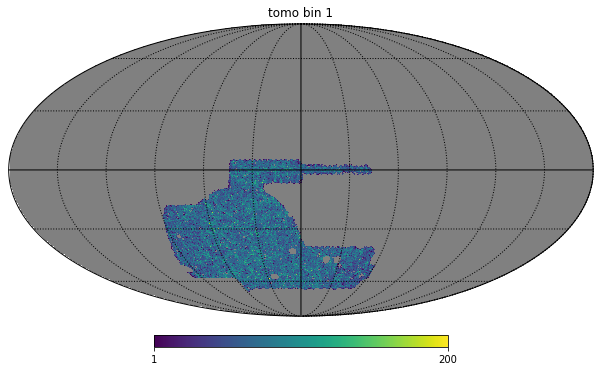

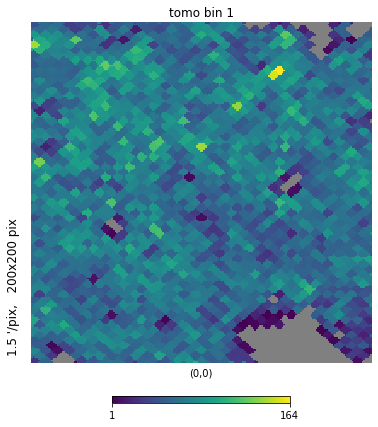

In [5]:
plot_patch(metacal_counts_tomo[0], title="tomo bin 1")

# N-body

In [6]:
patch_pix = metacal_patch_pix
anti_patch_pix = np.setdiff1d(np.arange(n_pix), patch_pix)

### load a Metacalibration like simulated delta map

In [7]:
# according to Marco this should be alright
metacal_bias = 1

In [9]:
# load fiducial cosmology
projected_maps_dir = "/Users/arne/data/CosmoGrid_example/DES/Fiducial/perm_0000/projected_probes_maps_nobaryons512.h5"

sim_counts_tomo = []
noisy_sim_counts_tomo = []
for tomo in tomo_range:
    with h5py.File(projected_maps_dir, "r") as f:
        dg_map = f[f"dg/desy3metacal{tomo}"][:]

    # normalize the number density contrast
    dg_map = (dg_map - np.mean(dg_map))/np.mean(dg_map)

    # number of galaxies per pixel
    sim_counts = (1+metacal_bias*dg_map)*n_bar
    noisy_sim_counts = np.random.poisson(sim_counts)
    noisy_sim_counts = noisy_sim_counts.astype(np.float32)

    # apply masking
    sim_counts[anti_patch_pix] = 0
    noisy_sim_counts[anti_patch_pix] = 0

    sim_counts_tomo.append(sim_counts)
    noisy_sim_counts_tomo.append(noisy_sim_counts)

n_gal = 2.5010e+07


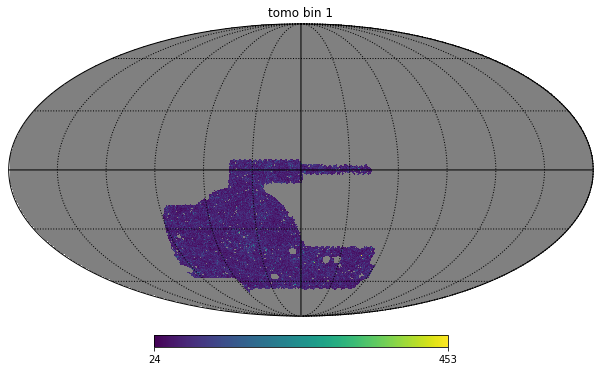

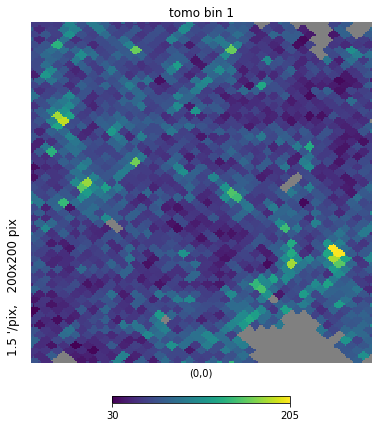

In [10]:
plot_patch(noisy_sim_counts_tomo[0], title="tomo bin 1")

# Comparison

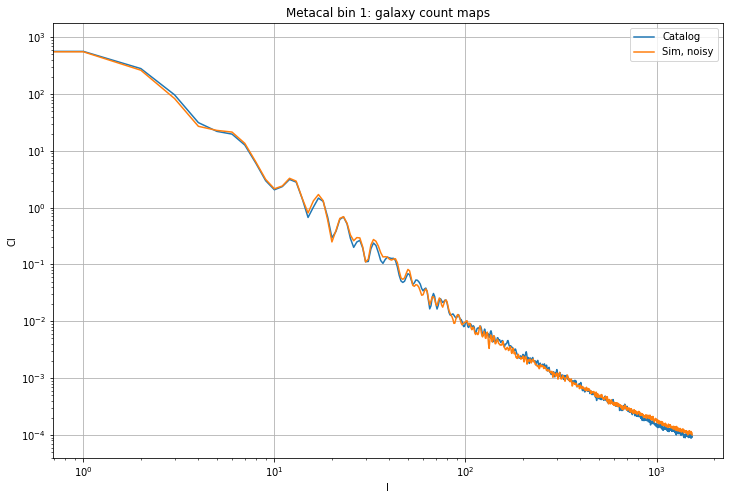

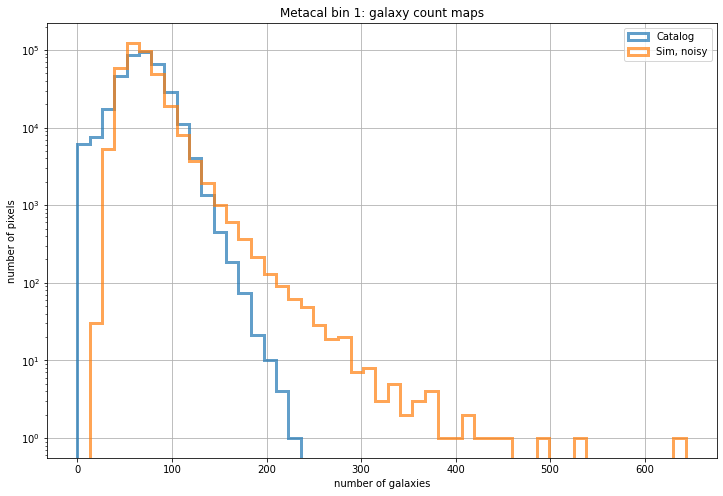

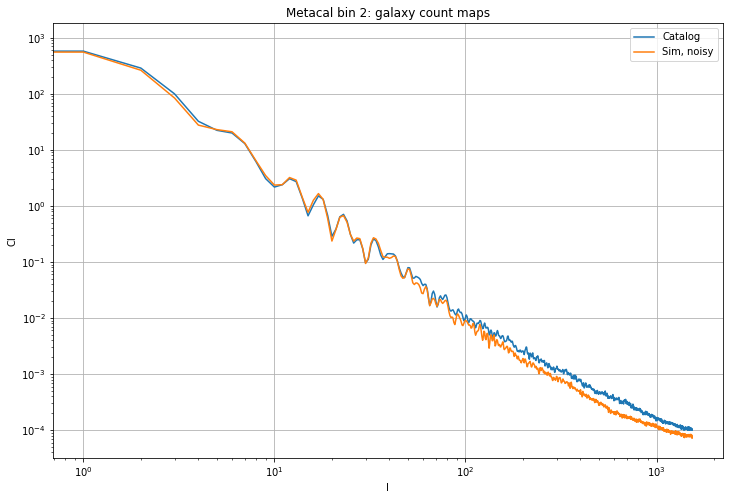

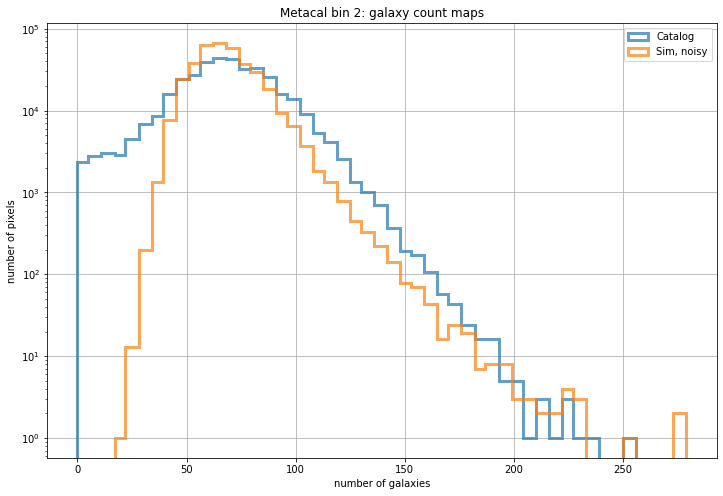

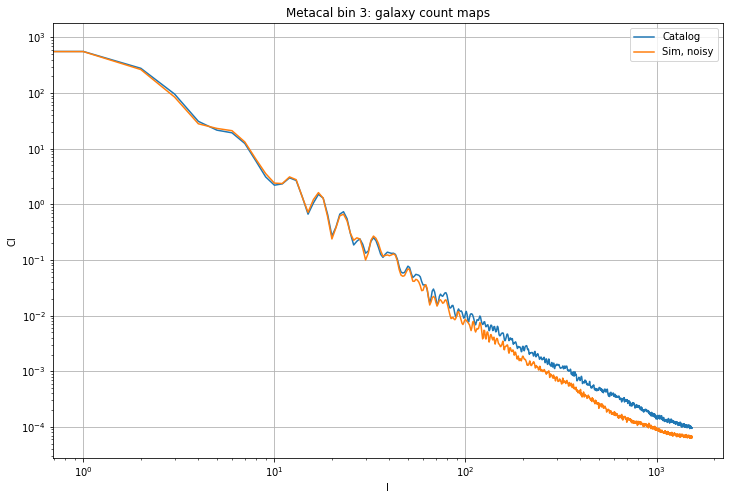

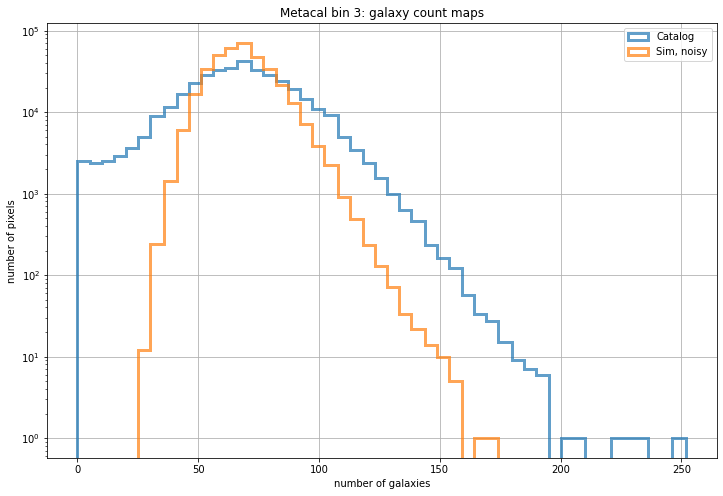

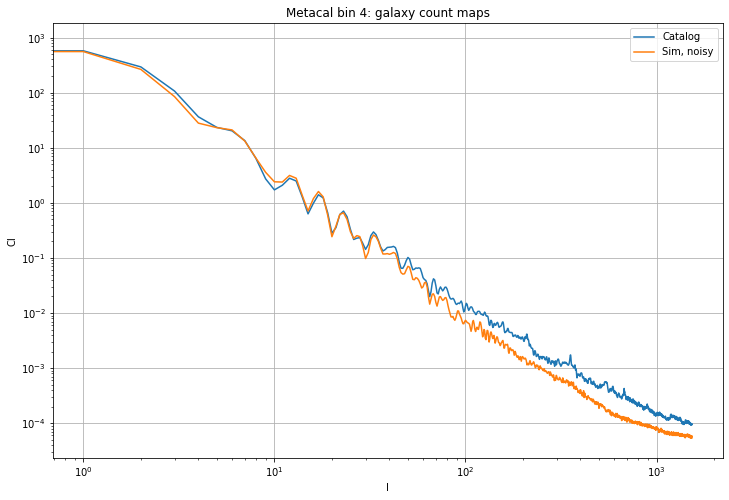

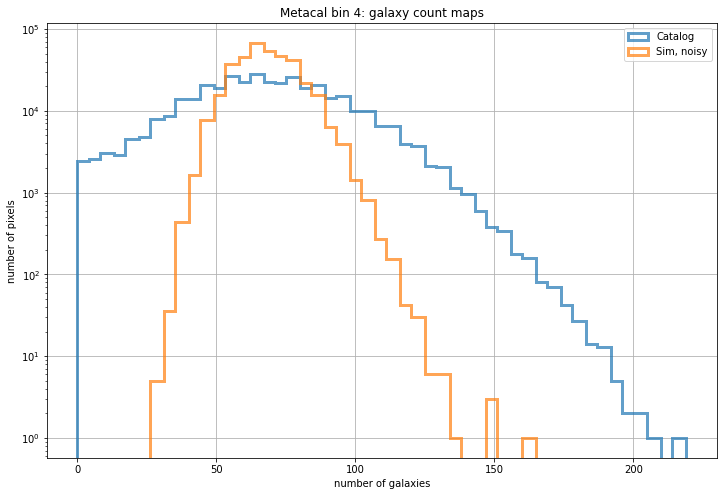

In [15]:
for i, tomo in enumerate(tomo_range):
    count_maps = [
        metacal_counts_tomo[i],
        # sim_counts_tomo[i],
        noisy_sim_counts_tomo[i],
    ]
    labels = [
        "Catalog",
        # "Sim, noiseless",
        "Sim, noisy",
    ]

    fig_cls, ax_cls = plt.subplots(figsize=(12,8))

    fig_hist, ax_hist = plt.subplots(figsize=(12,8))
    stacked_maps = np.stack(count_maps)
    bins = np.linspace(stacked_maps.min(), stacked_maps.max(), 50, dtype=int)

    for count_map, label in zip(count_maps, labels):    
        # consider the same patch for all
        count_map[anti_patch_pix] = 0

        cls = hp.anafast(count_map, use_pixel_weights=True)
        ax_cls.loglog(cls, label=label)

        ax_hist.hist(count_map[patch_pix], bins=bins, label=label, alpha=0.7, histtype="step", linewidth=3, log=True)

    ax_cls.legend()
    ax_cls.set(xlabel="l", ylabel="Cl", title=f"Metacal bin {tomo}: galaxy count maps")
    ax_cls.grid(True)

    ax_hist.legend()
    ax_hist.set(xlabel="number of galaxies", ylabel="number of pixels", title=f"Metacal bin {tomo}: galaxy count maps")
    ax_hist.grid(True)